# Pairs Trading using Eigenportfolios

This analysis shows an application of Principal Component Analysis in order to develop a pairs trading strategy to capture statistical arbitrage in the Precious Metals Market. 

We are going to look at how using PCA to create "eigenportfolios" can work as an alternative to using the standard method of looking for cointegration and mean reversion. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as ts 

import requests
import json

import datetime
import math

## Loading in the Precious Metals Datase

This dataset deals with the london fix spot prices for gold, silver, platinum, and palladium. 

It was taken from: 
https://www.perthmint.com/historical_metal_prices.aspx

In [2]:
# Old prices of gold dating back to 1922 - 2016

df_old = pd.read_csv('londonfixes.csv', error_bad_lines=False)
df_old = df_old.drop(df_old.columns[8:], axis=1)

/home/alex/.conda/envs/analysis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,6,8,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We only want to grab dates in the past 10 years, i.e. 2008 - 2018. In the old dataset, we only want to grab it to eoy 2015 from the old dataset

In [3]:
df_old.loc[14628]

Market            15/01/08
London Fix          904.75
London Fix.1        913.00
London Fix.2         16.24
London Fix.3      1,580.00
London Fix.4     1,575.00 
London Fix.5       379.00 
London Fix.6       378.50 
Name: 14628, dtype: object

In [4]:
df_old.loc[17530]

Market          28/12/15
London Fix           NaN
London Fix.1         NaN
London Fix.2         NaN
London Fix.3         NaN
London Fix.4         NaN
London Fix.5         NaN
London Fix.6         NaN
Name: 17530, dtype: object

In [5]:
df_old = df_old.loc[14628:17530].copy(deep=True)

In [6]:
# The dataset has a lot of erroneous fields
df_cur = pd.read_csv('londonfixes-current.csv', error_bad_lines=False)
df_cur = df_cur.drop(df_cur.columns[8:], axis=1)

b'Skipping line 6: expected 9 fields, saw 20\nSkipping line 7: expected 9 fields, saw 20\nSkipping line 8: expected 9 fields, saw 20\nSkipping line 14: expected 9 fields, saw 20\nSkipping line 15: expected 9 fields, saw 20\nSkipping line 21: expected 9 fields, saw 20\nSkipping line 22: expected 9 fields, saw 20\nSkipping line 28: expected 9 fields, saw 20\nSkipping line 29: expected 9 fields, saw 20\nSkipping line 35: expected 9 fields, saw 20\nSkipping line 36: expected 9 fields, saw 20\nSkipping line 42: expected 9 fields, saw 20\nSkipping line 43: expected 9 fields, saw 20\nSkipping line 49: expected 9 fields, saw 20\nSkipping line 50: expected 9 fields, saw 20\nSkipping line 56: expected 9 fields, saw 20\nSkipping line 57: expected 9 fields, saw 20\nSkipping line 63: expected 9 fields, saw 20\nSkipping line 64: expected 9 fields, saw 20\nSkipping line 70: expected 9 fields, saw 20\nSkipping line 71: expected 9 fields, saw 20\nSkipping line 77: expected 9 fields, saw 20\nSkipping li

In [7]:
df_cur = df_cur.append(df_old, ignore_index=True)
df_cur = df_cur.rename(index=str, columns={df_cur.columns[i]:df_cur.loc[0][df_cur.columns[i]] for i in range(len(df_cur.columns))})
df_cur = df_cur.rename(index=str, columns={'Metal/Currency': 'Date'})
df_cur.head(10)

,Date,Gold,Gold,Silver,Platinum,Platinum,Palladium,Palladium
0,Metal/Currency,Gold,Gold,Silver,Platinum,Platinum,Palladium,Palladium
1,Priced In,USD,USD,USD,USD,USD,USD,USD
2,Price Type,AM Fix,PM Fix,Fix,AM Fix,PM Fix,AM Fix,PM Fix
3,Summary,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,04/01/16,1072.7,1082.25,14,878,893,547,550
5,05/01/16,1078,1077,14.01,890,893,545,544
6,06/01/16,1083.85,1091.4,14.005,885,873,532,519
7,07/01/16,1096,1106.35,14.03,869,865,496,486
8,08/01/16,1097.45,1101.85,14.04,876,874,498,505
9,11/01/16,1104.7,1100.75,13.97,871,853,486,485


The london fix has an AM and PM fix for gold, platinum, and palladium, while it only has 1 fix for silver. 

Since we need to treat the AM and PM fix as different events, we separate this so that each fix represents a row in the dataset. Since Silver only has one fix, we will duplicate its fix price for both the AM and PM value. 

In [8]:
df_cur.columns=['Date', 'gold-am', 'gold-pm', 'silver-am', 'plat-am', 'plat-pm', 'pal-am', 'pal-pm']
# Get rid of 4 columns of metadata
df_cur = df_cur[4:]

df_new = pd.DataFrame()
# Mask out the first 4 rows that have metadata
df_new['date'] = pd.to_datetime(df_cur['Date'][4:], dayfirst=True)
df_new

# Clean the columns in the old dataset
# For some reason, calling .str.replace() on silver and palladium sometimes makes it all go to NaN. 
# We think this is some issue with Pandas because the column is of mixed types (integers and floats)
df_new['gold'] = pd.to_numeric(df_cur['gold-am'].str.replace(',',''))
df_new['plat'] = pd.to_numeric(df_cur['plat-am'].str.replace(',',''))
# Use Silver's value for BOTH AM and PM because it only has 1 fix price
df_new['silver'] = pd.to_numeric(df_cur['silver-am'])
df_new['pal'] = pd.to_numeric(df_cur['pal-am'])

# Do the same exact cleaning process for the current dataset
df_fake = df_new.copy(deep=True)
df_fake.date = df_fake.date+pd.Timedelta('8 hours')
df_fake['gold'] = pd.to_numeric(df_cur['gold-pm'].str.replace(',',''))
df_fake['plat'] = pd.to_numeric(df_cur['plat-pm'].str.replace(',',''))
# Use Silver's value for BOTH AM and PM because it only has 1 fix price
df_fake['silver'] = pd.to_numeric(df_cur['silver-am'])
df_fake['pal'] = pd.to_numeric(df_cur['pal-pm'].str.replace(',','').str.replace(' ', ''))

df_new = df_new.append(df_fake, ignore_index=True)
df_new = df_new.sort_values('date').reset_index()

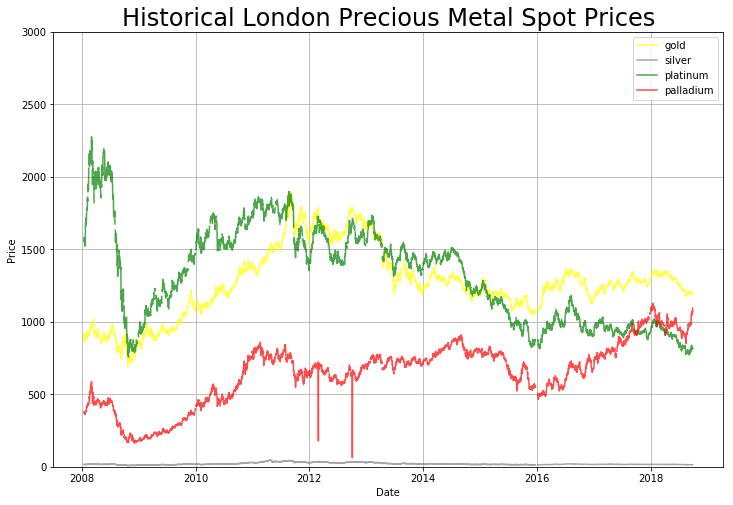

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(df_new['date'], df_new['gold'], color='yellow', label='gold', alpha=0.7)
plt.plot(df_new['date'], df_new['silver'], color='gray', label='silver', alpha=0.7)
plt.plot(df_new['date'], df_new['plat'], color='green', label='platinum', alpha=0.7)
plt.plot(df_new['date'], df_new['pal'], color='red', label='palladium', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Price')
plt.ylim([0, 3000])

plt.title('Historical London Precious Metal Spot Prices', fontsize=24)
plt.grid()
plt.legend()

Notice the drastic spikes in Palladium in 2012. 

We think this is due to some documentation error or some fluke, so we will exclude these values from our dataset. 

In [10]:
print(df_new.iloc[3000:6000].query('pal < 250'))
df_new.at[df_new.iloc[3000:6000].query('pal < 250').index, 'pal'] = np.nan
print(df_new.iloc[3000:6000].query('pal < 250'))

      index       date    gold    plat  silver    pal
3012   2210 2012-02-29  1788.0  1727.0   37.23  178.0
3444   2426 2012-10-04  1786.5  1698.0   34.96   62.0
Empty DataFrame
Columns: [index, date, gold, plat, silver, pal]
Index: []


## Testing for Cointegration/Correlation

Engle–Granger two-step method

If $x_t$ and $y_t$ are non-stationary and cointegrated, then a linear combination of them must be stationary. In other words:

$y_t − \beta x_t = u_t$ 

where $u_{t}$ is stationary.

If we knew $u_{t}$,  we could just test it for stationarity with something like a Dickey–Fuller test, Phillips–Perron test and be done. But because we don't know $u_{t}$, we must estimate this first, generally by using ordinary least squares, and then run our stationarity test on the estimated $u_{t}$ series, often denoted $\hat u_t$

A second regression is then run on the first differenced variables from the first regression, and the lagged residuals $\hat{{u}}_{t-1}$ is included as a regressor. 

In [11]:
# Performs unit root test and cointegration test for all pairs of metals

for metal1 in df_new.columns[2:]:
    for metal2 in df_new.columns[2:]:
        if metal1 == metal2:
            continue
        df_comp = df_new.query('{0} == {1} and {2} == {3}'.format(metal1, metal1, metal2, metal2))
        print('Cointegration Test for %s and %s' % (metal1, metal2))
        coint, pval, crit = ts.coint(df_comp[metal1], df_comp[metal2])
        print('Cointegration T-statistic: %0.2f' % coint)
        print('P-value: %0.5f' % pval)
        if pval < 0.05:
            print('SIGNIFICANT')
        else:
            print('INSIGNIFICANT')
        print('============================================================')

Cointegration Test for gold and plat
Cointegration T-statistic: -2.05
P-value: 0.50505
INSIGNIFICANT
Cointegration Test for gold and silver
Cointegration T-statistic: -2.41
P-value: 0.32034
INSIGNIFICANT
Cointegration Test for gold and pal
Cointegration T-statistic: -1.41
P-value: 0.79447
INSIGNIFICANT
Cointegration Test for plat and gold
Cointegration T-statistic: -2.14
P-value: 0.45755
INSIGNIFICANT
Cointegration Test for plat and silver
Cointegration T-statistic: -2.13
P-value: 0.46129
INSIGNIFICANT
Cointegration Test for plat and pal
Cointegration T-statistic: -2.06
P-value: 0.49829
INSIGNIFICANT
Cointegration Test for silver and gold
Cointegration T-statistic: -2.24
P-value: 0.40319
INSIGNIFICANT
Cointegration Test for silver and plat
Cointegration T-statistic: -2.25
P-value: 0.40104
INSIGNIFICANT
Cointegration Test for silver and pal
Cointegration T-statistic: -1.17
P-value: 0.86458
INSIGNIFICANT
Cointegration Test for pal and gold
Cointegration T-statistic: -0.52
P-value: 0.9626

# Eigenportfolio PCA Approach

We were unable to develop a pairs trading strategy using cointegration, so we will explore an alternative strategy. 

We are now going to use PCA (Principal Component Analysis) in order to decompose this historical market. 

PCA is a popular technique used in data science to reduce the dimensionality of the data while retaining as much information of the data as possible. 

## Fundamentals of Principal Component Analysis

We now perform Singular Value Decomposition of the Covariance Matrix. 

\begin{equation}
\underbrace{\mathbf{A^{T}A}}_{W \times D} = \underbrace{\mathbf{U}}_{W \times W} \times \underbrace{\mathbf{\Sigma}}_{W\times D} \times \underbrace{\mathbf{V}^{\text{T}}}_{D \times D} = 
\end{equation}

Where the $\mathbf{U}$ corresponds to the Left Principal Components, $\mathbf{\sigma}$ corresponds to the diagonlized Eigenvalues in ascending order, and $\mathbf{V^T}$ corresponds to the Right Principal Components.

Theoretically, PCA tries to project a $n$-dimensional space into a smaller $d$-dimensionsal space, where $n >> d$. 

It does this by decomposing the co-variance matrix, $\mathbf{A^{T}A}$ which is the matrix of datapoints whose $ij$th element is the covariance between the $i$th and $j$th element in a random vector. 

The principal components of the decomposition of the covariance matrix that capture the most information of the dataset whenever the dataset is projected onto that vector. The Eigenvalue that corresponds to that eigenvector is how strong that eigenvector explains the variance of the data. The left singular vectors tell us how much each particular row accounts for the variance of the data, while the right singular vectors tell us how much each particular column to the data. 

## Interpreting the Eigenvalues and Eigenvectors

Following from our knowledge of what PCA does fundamentally to an arbitrary dataset, how can we interpret it when applied to trading data?

Suppose we have a matrix $\mathbf{A \in \mathbb{R}^{mxn}}$ that represents a basket of $m$ stocks over $n$ days. Whenever we take take the Principal Component Analysis of this matrix, we are left with a decomposition of the left principal components multiplied by the eigenvales multiplied by the right principal vectors. 

The eigenvalues represent how much of the variance of the dataset is captured in each "concept" of the dataset. 

The left eigenvectors can be interpreted as how much the rows (a.k.a the stocks) correspond to each concept. 

The right eigenvectors can be interpreted as how much the columns (a.k.a the daily prices) correspond to each concept. 

In [12]:
df_svd = df_new[['date', 'gold', 'silver', 'plat', 'pal']]

# Clean out days where all indices have no entries (Holidays, Weekends)
df_svd = df_svd[~df_svd.iloc[:, 1:].isnull().all(1)]

df_svd.head(10)

,date,gold,silver,plat,pal
0,2008-01-15 00:00:00,904.75,16.240,1580.0,379.0
1,2008-01-15 08:00:00,913.00,16.240,1575.0,378.5
2,2008-01-16 00:00:00,881.00,15.850,1564.0,375.0
3,2008-01-16 08:00:00,889.75,15.850,1561.0,375.0
4,2008-01-17 00:00:00,881.50,15.880,1561.0,373.0
5,2008-01-17 08:00:00,888.25,15.880,1564.0,373.0
6,2008-01-18 00:00:00,872.75,15.825,1549.0,368.0
7,2008-01-18 08:00:00,882.00,15.825,1560.0,369.0
12,2008-01-21 00:00:00,874.25,15.770,1553.0,368.0
13,2008-01-21 08:00:00,871.25,15.770,1547.0,366.0


Normalize the price data to percent returns (current price - previous price)/previous price. 

We do this because PCA is sensitive to scale, and this serves as a form of normalization

In [13]:
def create_daily_returns_matrix(df):
    df_returns = pd.DataFrame()
    df_returns['date'] = df['date']
    for col in df.columns[1:]:
        df_returns[col] = df[col].pct_change()
    return df_returns

In [14]:
df_pct = create_daily_returns_matrix(df_svd).fillna(0)
df_pct.head(10)

,date,gold,silver,plat,pal
0,2008-01-15 00:00:00,0.000000,0.000000,0.000000,0.000000
1,2008-01-15 08:00:00,0.009119,0.000000,-0.003165,-0.001319
2,2008-01-16 00:00:00,-0.035049,-0.024015,-0.006984,-0.009247
3,2008-01-16 08:00:00,0.009932,0.000000,-0.001918,0.000000
4,2008-01-17 00:00:00,-0.009272,0.001893,0.000000,-0.005333
5,2008-01-17 08:00:00,0.007657,0.000000,0.001922,0.000000
6,2008-01-18 00:00:00,-0.017450,-0.003463,-0.009591,-0.013405
7,2008-01-18 08:00:00,0.010599,0.000000,0.007101,0.002717
12,2008-01-21 00:00:00,-0.008787,-0.003476,-0.004487,-0.002710
13,2008-01-21 08:00:00,-0.003432,0.000000,-0.003863,-0.005435


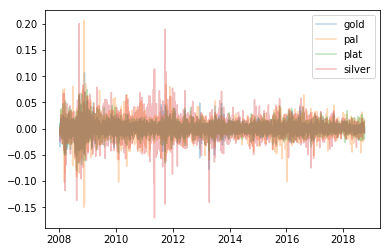

In [15]:
plt.plot(df_pct['date'], df_pct['gold'], alpha=0.3, label='gold')
plt.plot(df_pct['date'], df_pct['pal'], alpha=0.3, label='pal')
plt.plot(df_pct['date'], df_pct['plat'], alpha=0.3, label='plat')
plt.plot(df_pct['date'], df_pct['silver'], alpha=0.3, label='silver')
plt.legend()

In [16]:
vectorized = df_pct.iloc[:, 1:]
covariance = np.matmul(vectorized.T, vectorized)
covariance.shape

(4, 4)

In [17]:
eig_vals, eig_vecs = np.linalg.eig(covariance)
eig_vecs = eig_vecs.T
sort_indices = eig_vals.argsort()[::-1]
eig_vals = eig_vals[sort_indices]
eig_vecs = eig_vecs[sort_indices]

eig_vecs.shape

(4, 4)

In [18]:
eig_vals

array([2.19342899, 0.74448469, 0.29200908, 0.18062871])

In [19]:
eig_vecs

array([[ 0.26840565,  0.64736982,  0.41639983,  0.579208  ],
       [-0.1191753 , -0.68473208,  0.16942208,  0.69873842],
       [-0.6299813 ,  0.32777035, -0.60481533,  0.36040058],
       [ 0.71894313, -0.06797711, -0.65734752,  0.21539296]])

### Interpretation

After decomposing our covariance matrix, we get the above eigenvalues and eigenvectors. 

Each eigenvalue corresponds to the how much of the total variance of the data the corresponding principal component captures. 

The corresponding principal component represents a portfolio allocation that captures that amount of variance. 

In [20]:
def backtest(starting_alloc, starting_cash, df_pct, years=10, portfolio_name='10 Years Eigenportfolio', ax=None):
    # Using a risk-free rate
    ffr = 2
    alloc = [starting_cash]
    
    rel_returns = (df_pct.iloc[:, 1:]).copy(deep=True)
    for idx, item in enumerate(starting_alloc):
        sign = 1 if item > 0 else -1
        rel_returns.iloc[:, idx] = 1 + sign * rel_returns.iloc[:, idx]
        
    alloc = rel_returns.cumprod().multiply(np.absolute(starting_alloc), axis=1).sum(axis=1)
    # Plot returns
    if not ax:
        ax = plt.figure(figsize=(12, 8)).gca()
    ax.plot(df_pct['date'], alloc, label=portfolio_name, alpha=0.5)
    ax.grid()
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.set_title(portfolio_name)
    plt.legend()
    
    # Sharpe and Sortino Ratio
    port_returns= alloc.pct_change() * 100
    std_returns = np.std(port_returns) * math.sqrt(252)
    sortino_returns = np.std(port_returns.where(port_returns < 0)) * math.sqrt(252)
    tot_returns = (alloc.iloc[-1] - starting_cash)/alloc[0]
    sign_returns = 1 if tot_returns > 0 else -1
    
    annual_return = calc_annualized_return(np.absolute(tot_returns), years)* 100
    sharpe = sign * (annual_return - ffr)/std_returns
    sortino = sign * (annual_return - ffr) / sortino_returns
    print('Portfolio: %s' % portfolio_name)
    print('Sharpe Ratio: %0.3f' % sharpe)
    print('Sortino Ratio: %0.3f' % sortino)
    
    return alloc, rel_returns, sharpe, sortino

def calc_annualized_return(cum_return, years):
    tot_return = 1+cum_return
    return math.e ** (math.log(tot_return)/years)-1

Portfolio: 10 Years Principal Eigenportfolio
Sharpe Ratio: 0.112
Sortino Ratio: 0.140
Portfolio: 10 Years Equal Weight Portfolio
Sharpe Ratio: 0.090
Sortino Ratio: 0.115


Text(0.5, 1.0, 'Principal Eigenportfolio vs. Market')

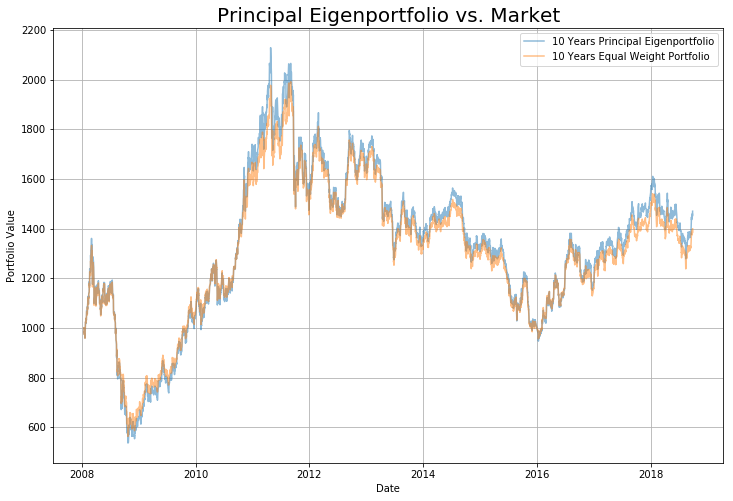

In [21]:
# Investing in the first principal eigenportfolio approximates the market as a whole. 
first_pc = eig_vecs[0]
first_pc = first_pc / np.sum(np.absolute(first_pc))

# Backtesting and comparing the weighted Eigenportfolio and an equal weight portfolio. 

starting_cash = 1000
principal_alloc = starting_cash * first_pc
equal_alloc = starting_cash * np.array([0.25, 0.25, 0.25, 0.25])

ax = plt.figure(figsize=(12, 8)).gca()

_, _, _, _ = backtest(principal_alloc, starting_cash, df_pct, years=10, portfolio_name='10 Years Principal Eigenportfolio', ax=ax)
_, _, _, _ = backtest(equal_alloc, starting_cash, df_pct, years=10, portfolio_name='10 Years Equal Weight Portfolio', ax=ax)

ax.grid()
ax.set_title('Principal Eigenportfolio vs. Market', fontsize=20)

## Krein's Theorem
When all assets have non-negative correlation, the coefficients of the first principal component are all non-negative. 

Therefore, the first principal component is the portfolio allocation that corresponds to market forces. The corresponding eigenvalue shows how much of the total variance of the data is explained by market forces. 

Text(0.5, 1.0, 'Spectral Analysis')

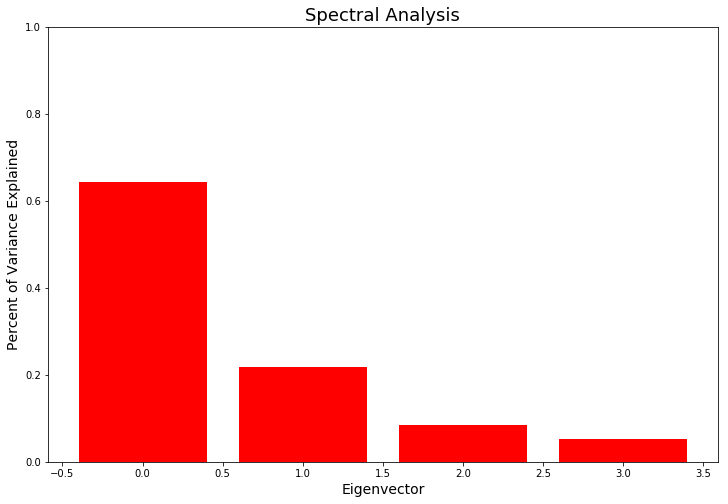

In [22]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(0, 4), eig_vals/sum(eig_vals), color='red')
plt.ylim([0, 1])
plt.xlabel('Eigenvector', fontsize=14)
plt.ylabel('Percent of Variance Explained', fontsize=14)
plt.title('Spectral Analysis', fontsize=18)

## Orthogonal Eigenvectors

It follows that all other eigenportfolios of the eigenbasis is orthogonal to the first principal component. This means that it's "uncorrelated" with the market, and hence, market neutral. 

Furthermore, since the principal component has all positive coefficients, the orthogonal eigenvectors must have at least 1 negative coefficient. 

Therefore, we claim that the orthogonal eigenvectors represent a market neutral pairs trading strategy that aims to capture the variance not explained by the market. 

This variance is comprised of intercompany reasons and noise. 

Portfolio: 10 Years 2nd Eigenportfolio
Sharpe Ratio: 0.108
Sortino Ratio: 0.144


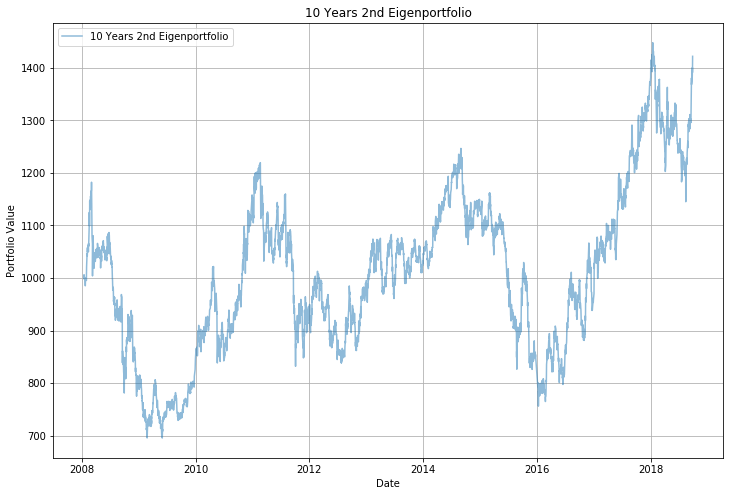

In [23]:
starting_cash = 1000
second_eig_alloc = eig_vecs[1]
second_eig_alloc = second_eig_alloc/sum(np.absolute(second_eig_alloc)) * 1000

_, _, _, _ = backtest(second_eig_alloc, starting_cash, df_pct, years=10, portfolio_name='10 Years 2nd Eigenportfolio')

## Backtesting

We will now try to backtest this algorithm by training on the first 8 years of historical data and then testing it on the final 2 years

In [24]:
df_pct.iloc[4500]

date      2016-12-16 00:00:00
gold               0.00701007
silver            -0.00557621
plat               -0.0109409
pal                -0.0522696
Name: 6292, dtype: object

In [25]:
vectorized_bt = df_pct.iloc[:4500, 1:]
covariance_bt = np.matmul(vectorized_bt.T, vectorized_bt)
covariance.shape

(4, 4)

In [26]:
eig_vals, eig_vecs = np.linalg.eig(covariance_bt)
eig_vecs = eig_vecs.T
sort_indices = eig_vals.argsort()[::-1]
eig_vals = eig_vals[sort_indices]
eig_vecs = eig_vecs[sort_indices]

eig_vecs.shape

(4, 4)

Now that we have the Eigenvectors corresponding to the daily returns of this basket of commodities, we will try to interpret them

Portfolio: 8 Years Principal Eigenportfolio
Sharpe Ratio: -0.002
Sortino Ratio: -0.002
Portfolio: 8 Years Equal Weight Portfolio
Sharpe Ratio: -0.018
Sortino Ratio: -0.023


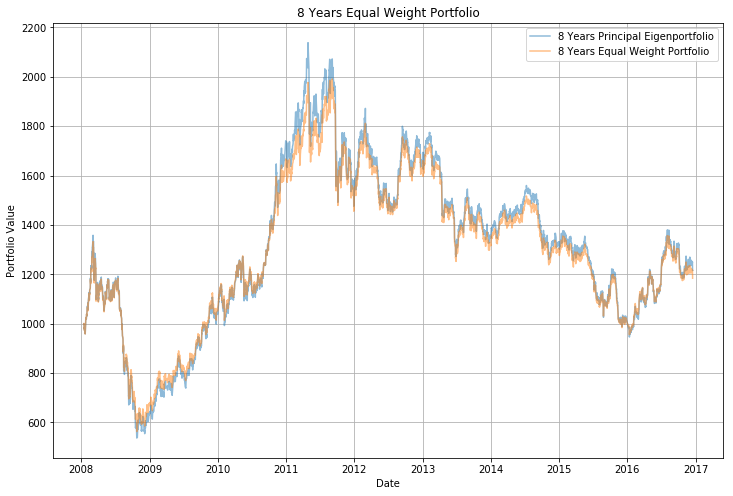

In [27]:
# Investing in the first principal eigenportfolio approximates the market as a whole. 
first_pc = eig_vecs[0]
first_pc = first_pc / np.sum(np.absolute(first_pc))

# Backtesting and comparing the weighted Eigenportfolio and an equal weight portfolio. 

starting_cash = 1000
principal_alloc = starting_cash * first_pc
equal_alloc = starting_cash * np.array([0.25, 0.25, 0.25, 0.25])

ax = plt.figure(figsize=(12, 8)).gca()

_, _, _, _ = backtest(principal_alloc, starting_cash, df_pct.iloc[:4500], years=10, portfolio_name='8 Years Principal Eigenportfolio', ax=ax)
_, _, _, _ = backtest(equal_alloc, starting_cash, df_pct[:4500], years=10, portfolio_name='8 Years Equal Weight Portfolio', ax=ax)

ax.grid()

Text(0.5, 1.0, 'Spectral Analysis')

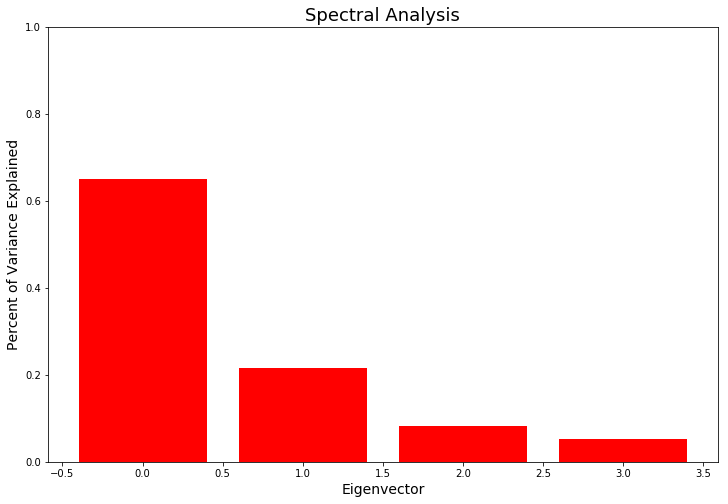

In [28]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(0, 4), eig_vals/sum(eig_vals), color='red')
plt.ylim([0, 1])
plt.xlabel('Eigenvector', fontsize=14)
plt.ylabel('Percent of Variance Explained', fontsize=14)
plt.title('Spectral Analysis', fontsize=18)

In [29]:
df_pct.iloc[4500:].reset_index()

,index,date,gold,silver,plat,pal
0,6292,2016-12-16 00:00:00,0.007010,-0.005576,-0.010941,-0.052270
1,6293,2016-12-16 08:00:00,-0.002864,0.000000,0.000000,-0.001451
2,6294,2016-12-19 00:00:00,0.005302,-0.003115,0.022124,-0.004360
3,6295,2016-12-19 08:00:00,-0.001187,0.000000,0.001082,-0.005839
4,6296,2016-12-20 00:00:00,-0.003080,-0.012500,-0.011892,-0.014684
5,6297,2016-12-20 08:00:00,-0.006224,0.000000,-0.006565,-0.008942
6,6298,2016-12-21 00:00:00,0.007729,0.014557,0.006608,-0.003008
7,6299,2016-12-21 08:00:00,-0.000661,0.000000,-0.002188,-0.006033
8,6300,2016-12-22 00:00:00,-0.002735,-0.016220,-0.002193,-0.009105
9,6301,2016-12-22 08:00:00,0.000708,0.000000,-0.004396,0.003063


Portfolio: Eigenportfolio
Sharpe Ratio: 1.093
Sortino Ratio: 1.578
Portfolio: Equal Allocation
Sharpe Ratio: 0.245
Sortino Ratio: 0.393


Text(0.5, 1.0, 'Eigenportfolio vs. Equal Allocation Portfolio')

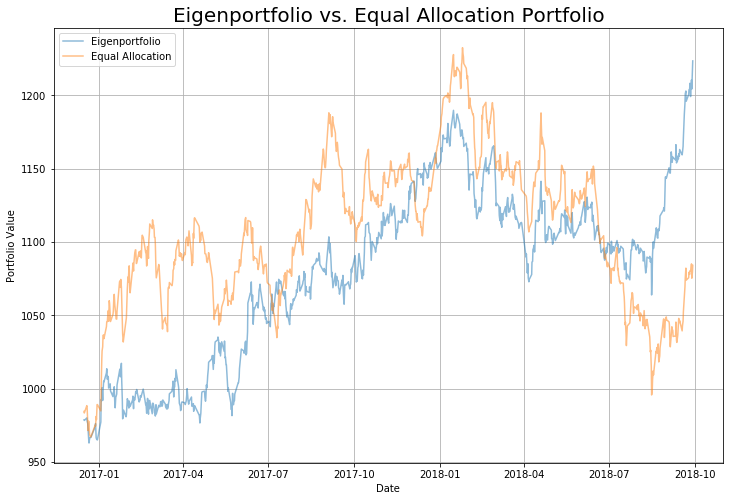

In [30]:
starting_cash = 1000
second_eig_alloc = eig_vecs[1]
second_eig_alloc = second_eig_alloc/sum(np.absolute(second_eig_alloc)) * 1000

ax = plt.figure(figsize=(12, 8)).gca()

_, _, _, _ = backtest(second_eig_alloc, starting_cash, df_pct.iloc[4500:].reset_index(drop=True), years=2, portfolio_name='Eigenportfolio', ax=ax)
_, _, _, _ = backtest(equal_alloc, starting_cash, df_pct.iloc[4500:].reset_index(drop=True), years=2, portfolio_name='Equal Allocation', ax=ax)

ax.grid()
ax.set_title('Eigenportfolio vs. Equal Allocation Portfolio', fontsize=20)

## Eigenportfolio

In [31]:
print(eig_vecs[1])

[-0.10754848 -0.67890968  0.19386913  0.69994981]


# Big Picture

* This technique is an interesting way to decompose a sector and potentially find market neutral pairs trading opportunities between different assets of a sector

# Caveats and Next Steps

* Volatility effects the eigenportfolios by a lot. We need to explore the effects of normalizing by volatility. 

* This assumes the market forces are linear. Will need to investigate results by using non-linear PCA

* This is constrained to groups of assets where all assets are correlated with each other to some degree. 

* Will need to look at backtesting results when eigenportfolios are dynamically updated.

* Assumes past trends will predict future trends


* look at very stable markets, medical equipment, construction, retail, semiconductor, things that are robust to policy related volatility